In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/feedback-prize-effectiveness/sample_submission.csv
/kaggle/input/feedback-prize-effectiveness/train.csv
/kaggle/input/feedback-prize-effectiveness/test.csv
/kaggle/input/feedback-prize-effectiveness/test/D72CB1C11673.txt
/kaggle/input/feedback-prize-effectiveness/train/87A6EF3113C6.txt
/kaggle/input/feedback-prize-effectiveness/train/24687D08CFDA.txt
/kaggle/input/feedback-prize-effectiveness/train/B64326635AB6.txt
/kaggle/input/feedback-prize-effectiveness/train/53858BE44997.txt
/kaggle/input/feedback-prize-effectiveness/train/02F89B4E55CF.txt
/kaggle/input/feedback-prize-effectiveness/train/4B048F74F3E7.txt
/kaggle/input/feedback-prize-effectiveness/train/62FC97D29846.txt
/kaggle/input/feedback-prize-effectiveness/train/FDE359A2F973.txt
/kaggle/input/feedback-prize-effectiveness/train/B72D0B4875B4.txt
/kaggle/input/feedback-prize-effectiveness/train/9A1DC81E4FB5.txt
/kaggle/input/feedback-prize-effectiveness/train/BACC53ECC1FB.txt
/kaggle/input/feedback-prize-effectiven

# **Solution for the Kaggle's Competition "Feedback Prize - Predicting Effective Arguments"**

Solution for the Kaggle competition "Feedback Prize - Predicting Effective Arguments - Rate the effectiveness of argumentative writing elements from students grade 6-12". The goal of this competition is to classify argumentative elements in student writing as "effective", "adequate" or "ineffective" creating a model using data that is representative of the 6th-12th grade population in the United States. The purpose is to provide students enhanced feedback on their argumentative writing with automated guidance using machine learning.

For this competition I will use a Long Short Term Memory network (LSTM) so we can consider all the sequence of data to make the classifications.

**Importing the necessary libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Loading the training and test datasets**

In [3]:
dataset_test = pd.read_csv("/kaggle/input/feedback-prize-effectiveness/test.csv")
dataset_train = pd.read_csv("/kaggle/input/feedback-prize-effectiveness/train.csv")

**Exploring and analysing the training set (EDA - Exploratory Data Analysis)**

In [4]:
dataset_train.head(5)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


We can see that the training set has no missing values, since all the columns has 36765 values being strings.

In [5]:
dataset_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36765 entries, 0 to 36764
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   discourse_id             36765 non-null  object
 1   essay_id                 36765 non-null  object
 2   discourse_text           36765 non-null  object
 3   discourse_type           36765 non-null  object
 4   discourse_effectiveness  36765 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


The unique values of "discourse_id" (36765) is differente compared to "discourse_text" (36691), indicating that there are duplicate values (assuming that for each discourse id, there is a unique discourse text associated).

In [6]:
dataset_train.describe()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
count,36765,36765,36765,36765,36765
unique,36765,4191,36691,7,3
top,0013cc385424,91B1F82B2CF1,Summer projects should be student-designed,Evidence,Adequate
freq,1,23,14,12105,20977


Here we can see all the duplicate results with also different "discourse_effectiveness" for a same "discourse_text".

In [7]:
duplicadas_geral = dataset_train[dataset_train.discourse_text.duplicated(keep=False)].sort_values(by="discourse_text")
duplicadas_geral

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
26691,7f9c3500259d,A602D45D22B2,"""That's a lava dome that takes the form of an ...",Evidence,Adequate
27350,d628a6adda3a,ADB68BCD2874,"""That's a lava dome that takes the form of an ...",Evidence,Adequate
25391,781452d9404c,942ECB176B3A,"At the most basic level, the electoral college...",Position,Adequate
28835,6fa171a95540,C2BAF4ADA2CA,"At the most basic level, the electoral college...",Claim,Adequate
28436,9e12ec699196,BB3A6C2D0B65,Big States,Claim,Adequate
...,...,...,...,...,...
27033,f6b2d34d9c01,A98E8EFFC8A9,the technology failing,Claim,Adequate
35488,bcdb6e47ede3,AB8EFBD82820,you can help others.,Claim,Ineffective
35493,98510222f9b8,AB8EFBD82820,you can help others.,Claim,Adequate
4788,d068e2c646e8,56C6D97AF40B,you get to see the world,Claim,Adequate


There's a total of 11 duplicated discourse texts with differente "discourse effectiveness".

In [8]:
duplicadas_analise = duplicadas_geral.groupby(["discourse_type", "discourse_text"]).discourse_effectiveness.nunique().to_frame().sort_values(by="discourse_effectiveness", ascending=False)
duplicadas_analise.columns = ["discourse_effectiveness_nonUnique"]
duplicadas_analise = duplicadas_analise[duplicadas_analise.discourse_effectiveness_nonUnique > 1].reset_index(drop=False)  
duplicadas_analise

,discourse_type,discourse_text,discourse_effectiveness_nonUnique
0,Claim,"opinions,",2
1,Claim,"Second, there could be a tie in the electoral ...",2
2,Claim,The Electoral College is unfair,2
3,Lead,"When people ask for advice, they sometimes tal...",2
4,Claim,Big States,2
5,Position,I would want to keep the Electoral College,2
6,Claim,you can help others.,2
7,Claim,"be creative,",2
8,Position,The author suggest that studying Venus is a wo...,2
9,Position,Seeking multiple opinions can help someone mak...,2


In [9]:
duplicadas_geral_analise = duplicadas_geral[duplicadas_geral.discourse_text.isin(duplicadas_analise.discourse_text)] 
duplicadas_geral_analise.head(10)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
28436,9e12ec699196,BB3A6C2D0B65,Big States,Claim,Adequate
20121,35bf70c4a673,4CA37D113612,Big States,Claim,Ineffective
20842,34b98386dc46,5729D5AE055C,I would want to keep the Electoral College,Position,Effective
28406,98154af4855d,BACC53ECC1FB,I would want to keep the Electoral College,Position,Adequate
11970,cc0dad1234ec,D8013F49DE51,Opponents say that cell phones are good becaus...,Counterclaim,Adequate
6570,dee3f8aec4fc,7742D58270C9,Opponents say that cell phones are good becaus...,Counterclaim,Ineffective
31753,b318a4e3b80e,EE2FC4219F49,"Second, there could be a tie in the electoral ...",Claim,Effective
31757,43848fd5dfb3,EE2FC4219F49,"Second, there could be a tie in the electoral ...",Claim,Adequate
35299,608e1d81f4ed,9627B47C10DE,Seeking multiple opinions can help someone mak...,Position,Effective
34383,3312a23a5480,523EBD9ECA47,Seeking multiple opinions can help someone mak...,Position,Adequate


**Visualizing some graphs**

Text(0, 0.5, 'Count')

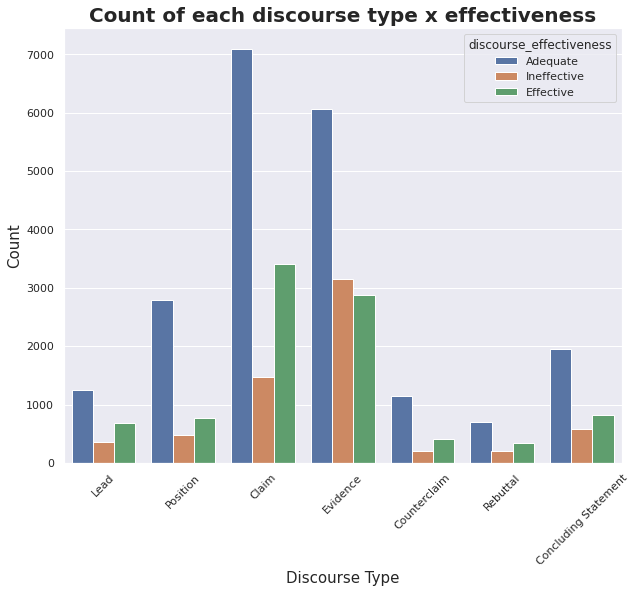

In [10]:
plt.figure(figsize=(10, 8))   # Contagem de cada classe de discurso das redações e as notas correspondentes
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="discourse_type", hue="discourse_effectiveness", data=dataset_train)
ax.tick_params(axis = "x", rotation = 45)
ax.set_title("Count of each discourse type x effectiveness", fontsize=20, weight='bold')
plt.xlabel("Discourse Type", fontsize=15)
plt.ylabel("Count", fontsize=15)

Text(0, 0.5, 'Count')

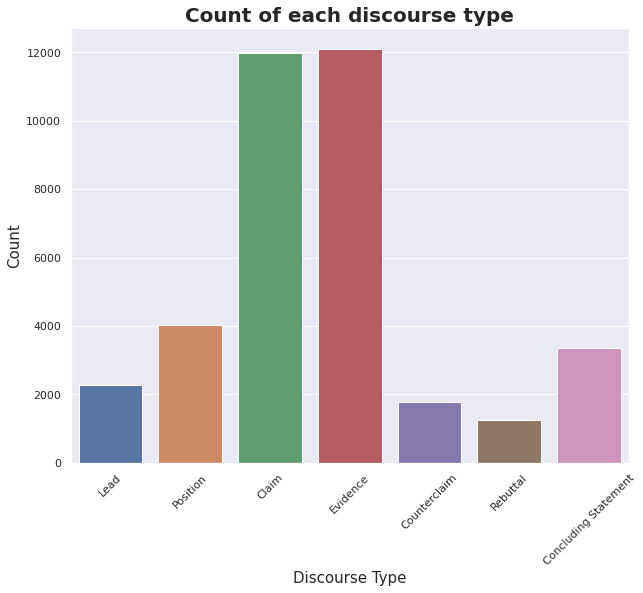

In [11]:
plt.figure(figsize=(10, 8))   # Contagem de cada classe de discurso das redações
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="discourse_type", data=dataset_train)
ax.tick_params(axis = "x", rotation = 45)
ax.set_title("Count of each discourse type", fontsize=20, weight='bold')
plt.xlabel("Discourse Type", fontsize=15)
plt.ylabel("Count", fontsize=15)

Text(0, 0.5, 'Count')

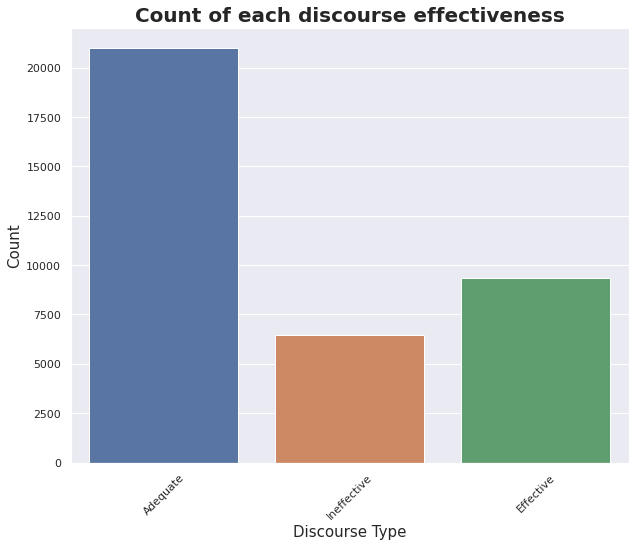

In [12]:
plt.figure(figsize=(10, 8))   # 
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="discourse_effectiveness", data=dataset_train)
ax.tick_params(axis = "x", rotation = 45)
ax.set_title("Count of each discourse effectiveness", fontsize=20, weight='bold')
plt.xlabel("Discourse Type", fontsize=15)
plt.ylabel("Count", fontsize=15)

We can see that, on average, each essay has approximately 9 "discourse_text":

In [13]:
discType_essayID = dataset_train.groupby(["essay_id"]).discourse_type.value_counts().to_frame()   # Contagem de "discourse_type" no training set para as "essay_id"
discType_essayID.columns = ["Contagem"]
discType_essayID.reset_index(drop=False, inplace=True)
discType_essayID = discType_essayID.pivot(index="essay_id", columns="discourse_type").Contagem

discType_essayID["Total_Sum"] = discType_essayID.sum(axis=1)  # Cria uma nova coluna com a soma de cada count do discourse type em cada linha
discType_essayID

discourse_type,Claim,Concluding Statement,Counterclaim,Evidence,Lead,Position,Rebuttal,Total_Sum
essay_id,,,,,,,,
00066EA9880D,3.0,1.0,NaN,3.0,1.0,1.0,NaN,9.0
000E6DE9E817,5.0,1.0,1.0,3.0,NaN,1.0,1.0,12.0
0016926B079C,7.0,NaN,NaN,3.0,NaN,1.0,NaN,11.0
00203C45FC55,1.0,1.0,3.0,3.0,1.0,1.0,3.0,13.0
0029F4D19C3F,2.0,1.0,1.0,2.0,1.0,1.0,1.0,9.0
...,...,...,...,...,...,...,...,...
FFA381E58FC6,2.0,1.0,NaN,1.0,NaN,1.0,NaN,5.0
FFC43F453EF6,4.0,1.0,3.0,1.0,NaN,1.0,1.0,11.0
FFD97A99CEBA,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0


In [14]:
discType_essayID.Total_Sum.mean()

8.772369362920545

Analyzing the words, chars and sentences counts to see the relationship with the quality rating:

In [15]:
dataset_train["discourse_text_numChars"] = dataset_train.discourse_text.apply(lambda x: len(x))
dataset_train["discourse_text_numWords"] = dataset_train.discourse_text.apply(lambda x: len(x.split()))
dataset_train["discourse_text_numSentences"] = dataset_train.discourse_text.apply(lambda x: len(tokenize.sent_tokenize(x, language="english")))

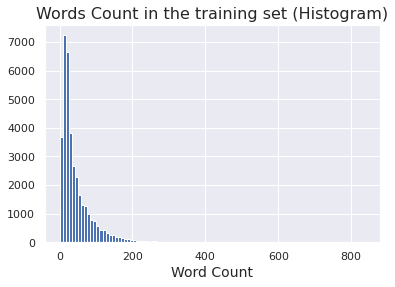

In [16]:
plt.hist(dataset_train["discourse_text_numWords"], bins=100)
plt.title("Words Count in the training set (Histogram)", size = 16)
plt.xlabel("Word Count", size = 14)
plt.show()

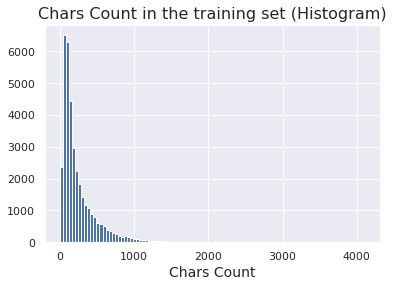

In [17]:
plt.hist(dataset_train["discourse_text_numChars"], bins=100)
plt.title("Chars Count in the training set (Histogram)", size = 16)
plt.xlabel("Chars Count", size = 14)
plt.show()

Text(0.5, 0, 'Word Count')

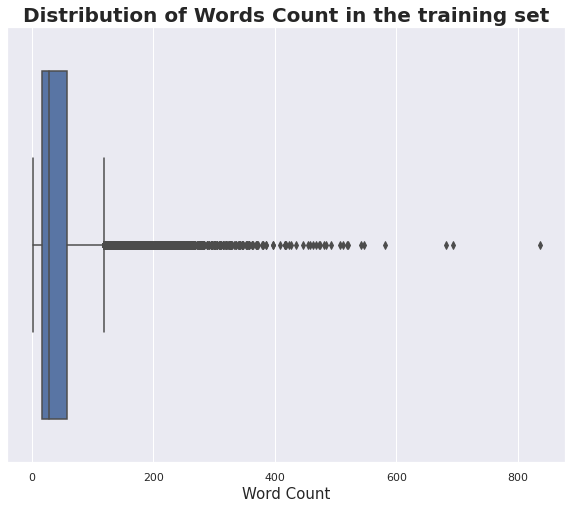

In [18]:
plt.figure(figsize=(10, 8))   
ax = sns.boxplot(x=dataset_train["discourse_text_numWords"])
ax.set_title("Distribution of Words Count in the training set", fontsize=20, weight='bold')
plt.xlabel("Word Count", fontsize=15)

It's possible to see that higher word counts tend to have better quality ratings:

Text(0, 0.5, 'Word Count')

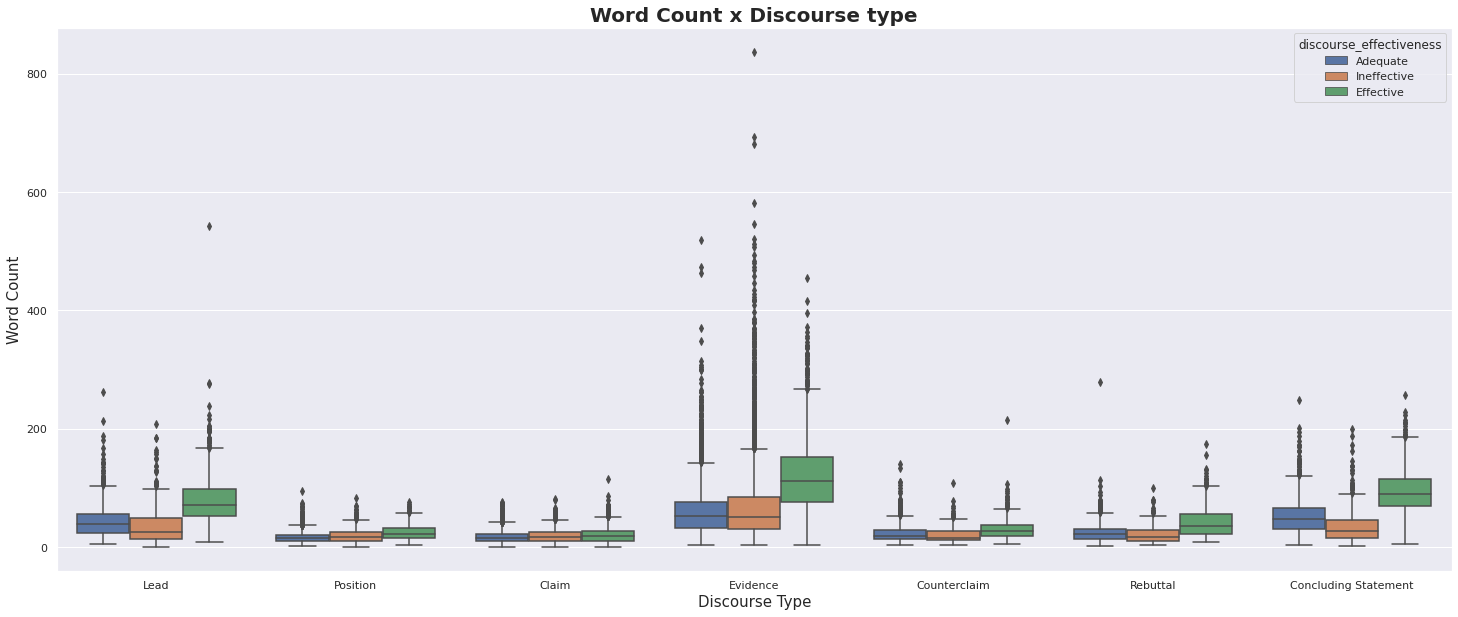

In [19]:
plt.figure(figsize=(25, 10))   
ax = sns.boxplot(x="discourse_type", y="discourse_text_numWords", hue="discourse_effectiveness", data=dataset_train)
#ax.tick_params(axis = "x", rotation = 45)
ax.set_title("Word Count x Discourse type", fontsize=20, weight='bold')
plt.xlabel("Discourse Type", fontsize=15)
plt.ylabel("Word Count", fontsize=15)

**Normalizing and tokenizing data to remove stopwords, lemmatization, removing special characters, etc.**

In [20]:
import sys
sys.path.insert(1, '/kaggle/input/text-preprocessing-and-normalization/')

import text_normalizer as tn
import model_evaluation_utils as meu

Encoding the "discourse_effectiveness" to numbers as it will be our output (prediction class labels):

In [21]:
dataset_train["discourse_effectiveness_encode"] = dataset_train.discourse_effectiveness.replace({"Ineffective": 0, "Adequate":1, "Effective": 2})

Concatenating the "discourse_type" with the "discourse_text" for the training and test set for our input (by concatenating, the algorithm will learn the features of discourse_text presented in each discourse_type).

In [22]:
dataset_train["inputs"] = dataset_train.discourse_type + " " + dataset_train.discourse_text
dataset_test["inputs"] = dataset_test.discourse_type + " " + dataset_test.discourse_text

In [23]:
dataset_train.head(3)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,discourse_text_numChars,discourse_text_numWords,discourse_text_numSentences,discourse_effectiveness_encode,inputs
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,317,67,3,1,"Lead Hi, i'm Isaac, i'm going to be writing ab..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,210,41,2,1,"Position On my perspective, I think that the f..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,105,21,1,1,Claim I think that the face is a natural landf...


Passing the dataframes to Numpy arrays:

In [24]:
train_inputs = np.array(dataset_train["inputs"])
test_inputs = np.array(dataset_test["inputs"])

Normalizing the training and test set:

In [25]:
norm_train_inputs = tn.normalize_corpus(train_inputs)
norm_test_inputs = tn.normalize_corpus(test_inputs)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


Tokenizing the training and test set:

In [26]:
tokenized_train = [tn.tokenizer.tokenize(text) for text in norm_train_inputs]
tokenized_test = [tn.tokenizer.tokenize(text) for text in norm_test_inputs]

**Building the model**

In [27]:
from collections import Counter

Building vocabulary mapping (word to index):

In [28]:
token_counter = Counter([token for discourse in tokenized_train for token in discourse])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)
# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

Vocabulary Size: 22989
Sample slice of vocabulary map: {'life': 11, 'make': 12, 'story': 13, 'nasa': 14, 'take': 15, 'picture': 16, 'see': 17, 'planet': 18, 'not': 19, 'know': 20}


Encoding and padding datasets and encoding prediction class labels:

In [29]:
from keras.preprocessing import sequence
#from keras.utils import pad_sequences       # Dependendo da versão do TensorFlow, não precisa rodar essa linha
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

Getting max length of train corpus and initializing label encoder

In [30]:
le = LabelEncoder()
num_classes=3 # Ineffective -> 0, Adequate -> 1, Effective -> 2
max_len = np.max([len(discourse) for discourse in tokenized_train])

Train discourses data corpus (converting tokenized text discourses to numeric vectors):

In [31]:
train_X = [[vocab_map[token] for token in tokenized_discourse] for tokenized_discourse in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len) # pad 

Train prediction class labels (text discourse labels (Ineffective\Adequate\Effective) to encodings (0/1/2) in one hot encoding).

In [32]:
enc = OneHotEncoder()

train_y = np.array(dataset_train["discourse_effectiveness_encode"])
train_y = train_y.reshape(-1, 1)
#train_y = enc.fit(train_y) 
train_y = enc.fit_transform(train_y) 
train_y = train_y.toarray()
#train_y = enc.transform(train_y).toarray()

Test discourses data corpus (converting tokenized text discourses to numeric vectors) and viewing vector shapes.

In [33]:
test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
           for token in tokenized_discourse] 
              for tokenized_discourse in tokenized_test]
test_X = sequence.pad_sequences(test_X, maxlen=max_len)

print('Max length of train discourse vectors:', max_len)
print('Train discourse vectors shape:', train_X.shape, ' Test discourse vectors shape:', test_X.shape)

Max length of train discourse vectors: 396
Train discourse vectors shape: (36765, 396)  Test discourse vectors shape: (10, 396)


Building the LSTM Model Architecture

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [35]:
EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
LSTM_DIM = 64 # total LSTM units

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(LSTM_DIM, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(3, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

#checkpointer = ModelCheckpoint(filepath="./classifier-{epoch:02d}.hdf5", verbose=1)
checkpointer = ModelCheckpoint(filepath="classifier-{epoch:02d}-{val_accuracy:.4f}.hdf5",
                               monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

earlyStop = EarlyStopping(
        monitor='val_accuracy',
        patience=2,
        verbose=1,
        mode='max',
        restore_best_weights=True
)

print(model.summary())

2022-07-24 19:36:04.048977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 19:36:04.050613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 19:36:04.051647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 19:36:04.052838: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 396, 128)          2942592   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 396, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 2,992,195
Trainable params: 2,992,195
Non-trainable params: 0
_________________________________________________________________
None


Visualizing model architecture

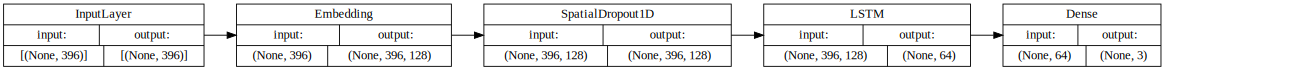

In [36]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='LR', dpi=65).create(prog='dot', format='svg'))

Training the model

In [37]:
batch_size = 100
#model.fit(train_X, train_y, epochs=5, batch_size=batch_size, 
model.fit(train_X, train_y, epochs=10, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, callbacks=[checkpointer, earlyStop], verbose=1)

2022-07-24 19:36:14.707416: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
331/331 [==============================] - 840s 3s/step - loss: 0.8534 - accuracy: 0.6250 - val_loss: 0.8819 - val_accuracy: 0.6024

Epoch 00001: val_accuracy improved from -inf to 0.60239, saving model to classifier-01-0.6024.hdf5
Epoch 2/10
331/331 [==============================] - 834s 3s/step - loss: 0.7592 - accuracy: 0.6626 - val_loss: 0.8390 - val_accuracy: 0.6250

Epoch 00002: val_accuracy improved from 0.60239 to 0.62497, saving model to classifier-02-0.6250.hdf5
Epoch 3/10
331/331 [==============================] - 838s 3s/step - loss: 0.7140 - accuracy: 0.6882 - val_loss: 0.8353 - val_accuracy: 0.6171

Epoch 00003: val_accuracy did not improve from 0.62497
Epoch 4/10
331/331 [==============================] - 834s 3s/step - loss: 0.6770 - accuracy: 0.7103 - val_loss: 0.8468 - val_accuracy: 0.6190

Epoch 00004: val_accuracy did not improve from 0.62497
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


**Submitting the model**

In [38]:
test_X.shape

(10, 396)

In [39]:
# Predictions
test_y = model.predict(test_X, verbose=1)
test_y

1/1 [==============================] - 0s 398ms/step


array([[0.02986792, 0.17412029, 0.7960118 ],
       [0.10713974, 0.739635  , 0.15322523],
       [0.09125963, 0.6129572 , 0.29578316],
       [0.11400492, 0.6692174 , 0.2167777 ],
       [0.08251359, 0.5863062 , 0.33118013],
       [0.07091919, 0.17549251, 0.7535883 ],
       [0.01525221, 0.13817997, 0.8465678 ],
       [0.08849423, 0.61054265, 0.30096316],
       [0.4194105 , 0.48233554, 0.09825391],
       [0.01804914, 0.13103114, 0.85091966]], dtype=float32)

Loading submission template to paste the predictions to and then saving the file:

In [40]:
submission_file = pd.read_csv("/kaggle/input/feedback-prize-effectiveness/sample_submission.csv")

submission_file

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.20,0.60,0.40
1,5a88900e7dc1,3.00,6.00,1.00
2,9790d835736b,1.00,2.00,3.00
3,75ce6d68b67b,0.33,0.34,0.33
4,93578d946723,0.01,0.24,0.47
5,2e214524dbe3,0.20,0.60,0.40
6,84812fc2ab9f,3.00,6.00,1.00
7,c668ff840720,1.00,2.00,3.00
8,739a6d00f44a,0.33,0.34,0.33
9,bcfae2c9a244,0.01,0.24,0.47


In [41]:
submission_file["Ineffective"] = test_y[:, 0]
submission_file["Adequate"] = test_y[:, 1]
submission_file["Effective"] = test_y[:, 2]

submission_file

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.029868,0.174120,0.796012
1,5a88900e7dc1,0.107140,0.739635,0.153225
2,9790d835736b,0.091260,0.612957,0.295783
3,75ce6d68b67b,0.114005,0.669217,0.216778
4,93578d946723,0.082514,0.586306,0.331180
5,2e214524dbe3,0.070919,0.175493,0.753588
6,84812fc2ab9f,0.015252,0.138180,0.846568
7,c668ff840720,0.088494,0.610543,0.300963
8,739a6d00f44a,0.419410,0.482336,0.098254
9,bcfae2c9a244,0.018049,0.131031,0.850920


In [42]:
submission_file.to_csv("submission.csv", index=False)